In [1]:
# Setup & imports

import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone
from IPython.display import display

# Custom Module Imports
from src.utils import data_loader, evaluation
from src.utils.training import trees
from src.utils.preprocessing.embeddings import base, word2vec

In [2]:
# Configuration
COHORT_NAME = "mimic_cohort_NF_30_days"
DATA_DIR = project_root / "data" / COHORT_NAME
CV_FOLDS_DIR = DATA_DIR / "cv_folds"

# Dimensions to test
DIMENSIONS_TO_TEST = [10, 50, 100, 1000]

# Load Master Data
cohort_path = str(DATA_DIR / f"{COHORT_NAME}.csv.gz")
codes_path  = str(DATA_DIR / f"{COHORT_NAME}_icd_codes.csv.gz")

df_target, df_codes, valid_ids = data_loader.load_processed_data(cohort_path, codes_path)

# Load Fold Files
fold_files = data_loader.get_fold_files(str(CV_FOLDS_DIR))

print(f"Data Loaded: {len(valid_ids)} patients")
print(f"Target Distribution:\n{df_target['label'].value_counts()}")

 Data Loaded. Total Patients in Cohort: 5308
Data Loaded: 5308 patients
Target Distribution:
label
0    5052
1     256
Name: count, dtype: int64


In [3]:
# Define Models
# Using factory functions from 'src.utils.training.trees'

models_map = {
    "XGBoost": trees.get_xgboost_model(),
    "RandomForest": trees.get_rf_model(),
    "CatBoost": trees.get_catboost_model()
}

In [4]:
# Main Execution Loop

leaderboard = []
print(f"--- Starting Word2Vec Evaluation (Dimensions: {DIMENSIONS_TO_TEST}) ---")

# Pre-calculate Sequences (Cleaned automatically by base.py)
sequences_dict = base.prepare_sequences(df_codes)

# Align Targets
y_aligned = df_target.set_index('hadm_id')['label']

for dim in DIMENSIONS_TO_TEST:
    print(f"\n[Processing Embedding Dimension: {dim}]")
    
    # Storage for metrics across 5 folds
    dim_results = {name: {"AUC": [], "F1": [], "Accuracy": []} for name in models_map}

    # Manual Cross-Validation Loop (Required for Dynamic Embeddings)
    for fold_idx, fold_file in enumerate(fold_files):
        # Load Fold & Merge Train+Val
        train_ids, val_ids, test_ids = data_loader.load_single_fold(fold_file)
        embedding_train_ids = np.concatenate([train_ids, val_ids])
        
        # Get Vectors (Handles Training & Vectorization internally)
        X_train_matrix, X_test_matrix = word2vec.get_fold_vectors(
            sequences_dict=sequences_dict,
            train_ids=embedding_train_ids,
            test_ids=test_ids,
            vector_size=dim
        )
        
        # Prepare DataFrames
        X_train_df = pd.DataFrame(X_train_matrix, index=embedding_train_ids)
        y_train_series = y_aligned.loc[embedding_train_ids]
        
        X_test_df = pd.DataFrame(X_test_matrix, index=test_ids)
        y_test_series = y_aligned.loc[test_ids]

        # Train & Evaluate Classifiers
        for model_name, model_template in models_map.items():
            model = trees.train_model(model_template, X_train_df, y_train_series)
            scores = evaluation.compute_metrics(model, X_test_df, y_test_series)
            
            dim_results[model_name]["AUC"].append(scores["AUC"])
            dim_results[model_name]["F1"].append(scores["F1"])
            dim_results[model_name]["Accuracy"].append(scores["Accuracy"])
            
    # Aggregate Results
    print(f"  > Results for Dim {dim}:")
    for model_name in models_map:
        avg_auc = np.mean(dim_results[model_name]["AUC"])
        print(f"    {model_name}: AUC={avg_auc:.4f}")
        
        leaderboard.append({
            "Dimension": dim,
            "Model": model_name,
            "AUC": avg_auc,
            "F1": np.mean(dim_results[model_name]["F1"]),
            "Accuracy": np.mean(dim_results[model_name]["Accuracy"])
        })

print("\n--- Evaluation Complete ---")

--- Starting Word2Vec Evaluation (Dimensions: [10, 50, 100, 1000]) ---

[Processing Embedding Dimension: 10]
  > Results for Dim 10:
    XGBoost: AUC=0.5917
    RandomForest: AUC=0.6275
    CatBoost: AUC=0.6114

[Processing Embedding Dimension: 50]
  > Results for Dim 50:
    XGBoost: AUC=0.6077
    RandomForest: AUC=0.6446
    CatBoost: AUC=0.6073

[Processing Embedding Dimension: 100]
  > Results for Dim 100:
    XGBoost: AUC=0.6111
    RandomForest: AUC=0.6341
    CatBoost: AUC=0.6120

[Processing Embedding Dimension: 1000]
  > Results for Dim 1000:
    XGBoost: AUC=0.5941
    RandomForest: AUC=0.6146
    CatBoost: AUC=0.5795

--- Evaluation Complete ---


In [5]:
# Process and Display Results

# Convert to DataFrame
results_df = pd.DataFrame(leaderboard)

# Sort by AUC
results_df = results_df.sort_values(by="AUC", ascending=False)

# Display Top Configurations
print("\nLeaderboard (Top Configurations)")
cols = ["Dimension", "Model", "AUC"]
display(results_df[cols].head(10))

# Identify Best
best_row = results_df.iloc[0]
print(f"\n Best Configuration: {best_row['Model']} (Dim={best_row['Dimension']}), AUC: {best_row['AUC']:.4f}")


Leaderboard (Top Configurations)


,Dimension,Model,AUC
4,50,RandomForest,0.644606
7,100,RandomForest,0.634116
1,10,RandomForest,0.627457
10,1000,RandomForest,0.614572
8,100,CatBoost,0.611951
2,10,CatBoost,0.611353
6,100,XGBoost,0.611093
3,50,XGBoost,0.607730
5,50,CatBoost,0.607271
9,1000,XGBoost,0.594142



 Best Configuration: RandomForest (Dim=50), AUC: 0.6446


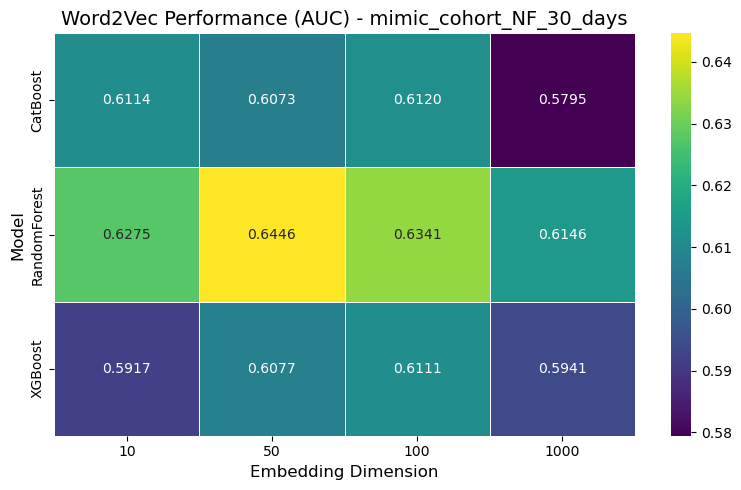

In [6]:
# Visualization

# We simply call the utility function, passing the raw leaderboard list
evaluation.plot_performance_heatmap(
    leaderboard=leaderboard,
    metric="AUC",
    title=f"Word2Vec Performance (AUC) - {COHORT_NAME}"
)